<a href="https://www.kaggle.com/code/jaygun84/american-express?scriptVersionId=110885010" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
from IPython.display import Image
Image(filename='../input/amex-images/Surviving-a-Credit-Card-Default.png', width="1100", height='50')


# **<span style="color:#87CEEB;">Problem Statement</span>**

- In this competition, you’ll apply your machine learning skills to predict credit default. Specifically, you will leverage an industrial scale data set to build a machine learning model that challenges the current model in production.

# **<span style="color:#87CEEB;">Data</span>**

The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

with the following features being categorical:

`['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']`

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric

- `train_data.csv` - training data with multiple statement dates per customer_ID
- `train_labels.csv - target label for each customer_ID
- `test_data.csv` - corresponding test data; your objective is to predict the target label for each customer_ID
- `sample_submission.csv` - a sample submission file in the correct format

# **<span style="color:#87CEEB;">Importing libraries</span>**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve
from matplotlib import style

plt.style.use('Solarize_Light2')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-images/Surviving-a-Credit-Card-Default.png
/kaggle/input/amex-default-prediction-feather/00_slim_data.ipynb
/kaggle/input/amex-default-prediction-feather/test.feather
/kaggle/input/amex-default-prediction-feather/train.feather
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
%%time
train_df = pd.read_feather('../input/amex-default-prediction-feather/train.feather')
test_df = pd.read_feather('../input/amex-default-prediction-feather/test.feather')
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
train_df.shape, test_df.shape

CPU times: user 36.8 s, sys: 12.3 s, total: 49.1 s
Wall time: 1min 6s


((5531451, 190), (11363762, 190))

In [3]:
pd.set_option('display.max_columns',None)

# **<span style="color:#87CEEB;">Data Merging</span>**

In [4]:
#%time train_df = train_df.merge(train_labels, on='customer_ID', how='left')

CPU times: user 1min 1s, sys: 23 s, total: 1min 24s
Wall time: 1min 24s


In [4]:
train_df=train_df.iloc[:200000]

In [5]:
train_df

customer_ID         S_2  \
0       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09   
1       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07   
2       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28   
3       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13   
4       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16   
...                                                   ...         ...   
199995  09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5...  2017-08-28   
199996  09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5...  2017-09-15   
199997  09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5...  2017-10-10   
199998  09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5...  2017-11-16   
199999  09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5...  2017-12-15   

             P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0       0.938477  0.001734  0.008728  1.006836  0.009224  0.124023  0.008774   
1       0.936523  0.005775  0.004925  1.000977  0.006153  0.126709  0.000798   
2       0.954102  0.091492  0.021652  1.009766  0.006817  0.123962  0.007599   
3       0.960449  0.002455  0.013687  1.002930  0.001372  0.117188  0.000685   
4       0.947266  0.002483  0.015190  1.000977  0.007607  0.117310  0.004654   
...          ...       ...       ...       ...       ...       ...       ...   
199995  0.539062  0.002428  0.006172  1.006836  0.007721  0.155396  0.002317   
199996  0.545898  0.062134  0.014534  0.816406  0.009415  0.145874  0.007355   
199997  0.579590  0.009155  0.010880  0.814941  0.005642  0.149658  0.001961   
199998  0.577637  0.090149  0.013901  1.008789  0.007107  0.153809  0.004684   
199999  0.655273  0.002060  0.022369  1.007812  0.006149  0.151367  0.009964   

             B_3  D_42      D_43      D_44       B_4      D_45       B_5  \
0       0.004707   NaN       NaN  0.000630  0.080994  0.708984  0.170654   
1       0.002714   NaN       NaN  0.002525  0.069397  0.712891  0.113220   
2       0.009422   NaN       NaN  0.007607  0.068848  0.720703  0.060486   
3       0.005531   NaN       NaN  0.006405  0.055634  0.724121  0.166748   
4       0.009308   NaN       NaN  0.007732  0.038849  0.720703  0.143677   
...          ...   ...       ...       ...       ...       ...       ...   
199995  0.014580   NaN  0.008919  0.132324  0.005547  0.085876  0.026291   
199996  0.011436   NaN  0.015038  0.131470  0.020599  0.083618  0.012177   
199997  0.008331   NaN  0.009933  0.128540  0.014221  0.087402  0.012390   
199998  0.010483   NaN  0.009041  0.134766  0.125122  0.089050  0.004986   
199999  0.003983   NaN  0.008766  0.129150  0.090210  0.096191  0.010811   

             R_2      D_46      D_47      D_48  D_49       B_6       B_7  \
0       0.006203  0.358643  0.525391  0.255615   NaN  0.063904  0.059418   
1       0.006207  0.353516  0.521484  0.223389   NaN  0.065247  0.057739   
2       0.003260  0.334717  0.524414  0.189453   NaN  0.066956  0.056641   
3       0.009918  0.323242  0.530762  0.135620   NaN  0.083740  0.049255   
4       0.006668  0.230957  0.529297       NaN   NaN  0.075928  0.048920   
...          ...       ...       ...       ...   ...       ...       ...   
199995  0.001900  0.497070  0.732910  0.140991   NaN  0.121399  0.019989   
199996  0.009155  0.502441  0.731445  0.138062   NaN  0.138306  0.022339   
199997  0.002905  0.582031  0.736816  0.122559   NaN  0.086975  0.017380   
199998  0.001038  0.524902  0.740234  0.099792   NaN  0.079102  0.100159   
199999  0.002115  0.467529  0.735840  0.087097   NaN  0.079773  0.076111   

             B_8      D_50      D_51       B_9       R_3      D_52       P_3  \
0       0.006466  0.148682  1.335938  0.008209  0.001423  0.207275  0.736328   
1       0.001614  0.149780  1.339844  0.008369  0.001984  0.202759  0.720703   
2       0.005127  0.151978  1.336914  0.009354  0.007427  0.206665  0.738281   
3       0.001417  0.151245  1.339844  0.006783  0.003515  0.20

In [6]:
tmp=train_labels["target"].value_counts(normalize=True)*100

In [7]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x=tmp.index, y=tmp.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

In [8]:
deliq=[i for i in train_df.columns if i.startswith("D")]
spend=[i for i in train_df.columns if i.startswith("S")]
payment=[i for i in train_df.columns if i.startswith("P")]
balance=[i for i in train_df.columns if i.startswith("B")]
risk=[i for i in train_df.columns if i.startswith("R")]

In [9]:
train_df[deliq].describe(include="all")

D_39          D_41          D_42          D_43           D_44  \
count  2.000000e+05  1.999280e+05  29193.000000  1.399420e+05  190071.000000   
mean   0.000000e+00  0.000000e+00      0.181274  0.000000e+00       0.000000   
std    0.000000e+00  0.000000e+00      0.216797  0.000000e+00       0.000000   
min    4.172325e-07  5.960464e-08     -0.000219  8.940697e-07       0.000000   
25%    4.542351e-03  2.897263e-03      0.039459  4.235840e-02       0.003895   
50%    9.063721e-03  5.767822e-03      0.120728  8.831787e-02       0.007755   
75%    2.359619e-01  8.651733e-03      0.250732  1.850586e-01       0.132324   
max    5.332031e+00  6.796875e+00      3.251953  9.085938e+00       2.880859   

                D_45           D_46           D_47           D_48  \
count  199928.000000  156105.000000  200000.000000  173989.000000   
mean        0.000000            NaN            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min         0.000002      -3.943359      -0.026627      -0.009605   
25%         0.053894       0.425049       0.233398       0.083557   
50%         0.181885       0.459717       0.380615       0.296875   
75%         0.372559       0.516602       0.554688       0.679199   
max         1.561523       5.097656       1.299805       2.857422   

               D_49          D_50          D_51           D_52          D_53  \
count  20462.000000  86464.000000  2.000000e+05  198991.000000  5.259700e+04   
mean       0.188843      0.000000  0.000000e+00       0.000000  7.623291e-02   
std        0.195068      0.000000  0.000000e+00       0.000000  1.999512e-01   
min        0.000018     -3.126953  2.980232e-07      -0.007030  4.172325e-07   
25%        0.062683      0.064209  3.654480e-03       0.073669  6.198883e-03   
50%        0.132568      0.109070  7.301331e-03       0.143066  1.364899e-02   
75%        0.254150      0.183228  3.361816e-01       0.230469  5.187988e-02   
max        2.921875     40.406250  2.009766e+00       1.009766  4.953125e+00   

                D_54           D_55          D_56          D_58  \
count  199928.000000  193476.000000  91119.000000  2.000000e+05   
mean             NaN       0.000000      0.000000  0.000000e+00   
std         0.000000       0.000000      0.000000  0.000000e+00   
min        -0.001986       0.000001     -0.015411  1.788139e-07   
25%         1.001953       0.058624      0.088928  5.863190e-03   
50%         1.004883       0.186890      0.151123  1.083374e-01   
75%         1.007812       0.511230      0.249023  3.754883e-01   
max         1.009766       1.803711      6.667969  1.261719e+00   

                D_59          D_60           D_61           D_62  \
count  196233.000000  2.000000e+05  178557.000000  172567.000000   
mean             NaN           NaN            NaN       0.000000   
std         0.000000  0.000000e+00       0.000000       0.000000   
min        -0.083191  2.384186e-07      -0.009254      -0.002172   
25%         0.237305  3.146362e-02       0.093994       0.030701   
50%         0.379639  2.297363e-01       0.381592       0.091309   
75%         0.468262  6.958008e-01       0.783203       0.278076   
max         1.981445  1.009766e+00       8.562500       4.347656   

                D_63           D_64           D_65           D_66  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.930105       1.612815       0.000000      -0.779345   
std         0.544345       1.021454       0.000000       0.625682   
min         0.000000      -1.000000       0.000000      -1.000000   
25%         1.000000       1.000000       0.002607      -1.000000   
50%         1.000000       1.000000       0.005230      -1.000000   
75%         1.000000       3.000000       0.007851      -1.000000   
max         5.000000       3.000000      34.250000       1.000000   

               D_68          D_69          D_70           D_71           D_72  \
count  200000.00000  1.930060e+

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

In [6]:
cat_col=['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [12]:
train_df[cat_col]=train_df[cat_col].astype("category")

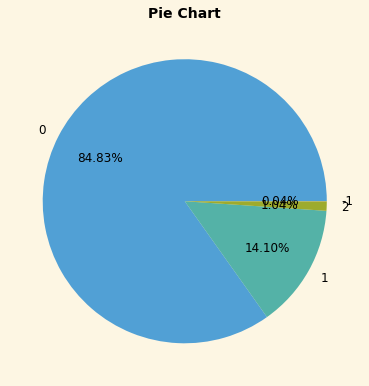

In [13]:
labels=train_df['B_30'].dropna().unique()
order=train_df['B_30'].value_counts().index
plt.figure(figsize=(14,14))
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14)
plt.pie(train_df['B_30'].value_counts(), labels=order, pctdistance=0.67, autopct='%.2f%%',
        wedgeprops=dict(alpha=0.8), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white')
plt.show()

In [9]:
all_cols = [c for c in list(train_df.columns) if c not in ['customer_ID','S_2']]
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
num_features = [col for col in all_cols if col not in cat_features]

num_df = train_df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
num_df.columns = ['_'.join(x) for x in num_df.columns]

cat_df=train_df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
cat_df.columns = ['_'.join(x) for x in cat_df.columns]
main_df=pd.concat([num_df,cat_df], axis=1)

In [10]:
main_df

P_2_mean   P_2_std  \
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.933594  0.024194   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.899902  0.022097   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.878418  0.028837   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.599121  0.020082   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.891602  0.042316   
...                                                      ...       ...   
0956f2eafc5d8919835f76f6e40835b49900cf91c3de18c...  0.678223  0.122665   
0956f6dbb2671e10a40180b39ea793fb73633767ef70be1...  0.878418  0.018330   
095700a5c40952f9c134c6a71700bbd959098adfdcf2c73...  0.658203  0.036290   
09572daa668d689b39d22d8a6a234d48141259b0675b0d2...  0.855469  0.022351   
09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5a...  0.590820  0.033357   

                                                     P_2_min   P_2_max  \
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.868652  0.960449   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.861328  0.929199   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.797852  0.904297   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.567383  0.623535   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.805176  0.940430   
...                                                      ...       ...   
0956f2eafc5d8919835f76f6e40835b49900cf91c3de18c...  0.375488  0.828125   
0956f6dbb2671e10a40180b39ea793fb73633767ef70be1...  0.838379  0.921387   
095700a5c40952f9c134c6a71700bbd959098adfdcf2c73...  0.578613  0.716309   
09572daa668d689b39d22d8a6a234d48141259b0675b0d2...  0.833008  0.880859   
09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5a...  0.539062  0.655273   

                                                    P_2_last  D_39_mean  \
customer_ID                                                               
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.934570   0.010704   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.880371   0.215210   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.880859   0.004181   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.621582   0.048859   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.872070   0.004642   
...                                                      ...        ...   
0956f2eafc5d8919835f76f6e40835b49900cf91c3de18c...  0.375488   0.156372   
0956f6dbb2671e10a40180b39ea793fb73633767ef70be1...  0.871094   0.004776   
095700a5c40952f9c134c6a71700bbd959098adfdcf2c73...  0.687988   0.186768   
09572daa668d689b39d22d8a6a234d48141259b0675b0d2...  0.877930   0.066833   
09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5a...  0.655273   0.018723   

                                                    D_39_std  D_39_min  \
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.024440  0.001082   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.199123  0.002224   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.002759  0.000802   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.088490  0.000660   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.002883  0.000030   
...                                                      ...       ...   
0956f2eafc5d8919835f76f6e40835b49900cf91c3de18c...  0.277608  0.000146   
0956f6dbb2671e10a40180b39ea793fb73633767ef70be1...  0.002874  0.000003   
095700a5c40952f9c134c6a71700bbd959098adfdcf2c73...  0.191895  0.002926   
09572daa668d689b39d22d8a6a234d48141259b0675b0d2...  0.078206  0.004055   
09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5a...  0.031087  0.002060   

                                                    D_39_max  D_39_last  \
customer_ID                                                               
0000099d6bd597052cdcda90ffabf56573fe9

In [11]:
%time train_df = main_df.merge(train_labels, on='customer_ID', how='left')

CPU times: user 281 ms, sys: 3.28 ms, total: 285 ms
Wall time: 295 ms


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


In [12]:
train_df["target"].value_counts(normalize=True)

0    0.73528
1    0.26472
Name: target, dtype: float64

In [15]:
train_df["customer_ID"].value_counts()

0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    1
063a6ae77a4b1db112dc207e7e7efb248dda1803c30a369d5c9f56efbd96b466    1
0634efd63b66554fc960a3a15af4c6b73e45155b419ed7686b63cd4b8f7b9f32    1
06350932cd8d2dc5b2974c871731d5f98cd62d4bee580e8e5af296ee82baf657    1
06353665d333f35d81567795adba92a6f95a6277c8ccfa4907fe379741fe0410    1
                                                                   ..
03180a7c683bff5c3279fca42b0f90d87f62d270bb29f5f24c0fc114bcd6e478    1
031855ebc4c572c9423cfd950f692e1f57c6d14fb144ba7cc8b673c7bdab2c4d    1
03185b177aa297e668568fc031a4e600f92761b1d68d1f409b78c4e8e04c56d5    1
03185d296f983e9fce73f9a454d825252e256b348852e3403663be5521de1708    1
09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5a2d1e1a4a474ab5382    1
Name: customer_ID, Length: 16576, dtype: int64

In [17]:
cust=pd.DataFrame(train_df["customer_ID"].value_counts())

In [30]:
cust

customer_ID         S_2       P_2  \
0   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938477   
1   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936523   
2   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954102   
3   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960449   
4   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947266   
5   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-08-04  0.945801   
6   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-09-18  0.940918   
7   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-10-08  0.914551   
8   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-11-20  0.950684   
9   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-12-04  0.868652   
10  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2018-01-11  0.909668   
11  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2018-02-21  0.937500   
12  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2018-03-13  0.934570   

        D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0   0.001734  0.008728  1.006836  0.009224  0.124023  0.008774  0.004707  ...   
1   0.005775  0.004925  1.000977  0.006153  0.126709  0.000798  0.002714  ...   
2   0.091492  0.021652  1.009766  0.006817  0.123962  0.007599  0.009422  ...   
3   0.002455  0.013687  1.002930  0.001372  0.117188  0.000685  0.005531  ...   
4   0.002483  0.015190  1.000977  0.007607  0.117310  0.004654  0.009308  ...   
5   0.001746  0.007866  1.004883  0.004219  0.110962  0.009857  0.009865  ...   
6   0.002182  0.018860  1.007812  0.004509  0.103333  0.006603  0.000783  ...   
7   0.003029  0.014328  1.000000  0.000263  0.108093  0.009529  0.007835  ...   
8   0.009895  0.016891  1.003906  0.001789  0.102783  0.002520  0.009819  ...   
9   0.001082  0.001930  1.007812  0.001772  0.100464  0.004627  0.006073  ...   
10  0.005714  0.002829  1.004883  0.008179  0.098877  0.001853  0.003239  ...   
11  0.002424  0.019836  1.008789  0.000607  0.102966  0.006172  0.007454  ...   
12  0.009117  0.009384  1.007812  0.006104  0.135010  0.001604  0.007175  ...   

       D_139     D_140     D_141  D_142     D_143     D_144     D_145  target  \
0   0.002426  0.003706  0.003819    NaN  0.000569  0.000610  0.002674       0   
1   0.003956  0.003166  0.005032    NaN  0.009575  0.005493  0.009216       0   
2   0.003269  0.007328  0.000427    NaN  0.003429  0.006985  0.002604       0   
3   0.006119  0.004517  0.003201    NaN  0.008423  0.006527  0.009598       0   
4   0.003672  0.004944  0.008888    NaN  0.001670  0.008125  0.009827       0   
5   0.001925  0.008598  0.004528    NaN  0.000674  0.002222  0.002884       0   
6   0.001336  0.004360  0.009384    NaN  0.007729  0.007660  0.002224       0   
7   0.002398  0.008453  0.005554    NaN  0.001831  0.009613  0.007385       0   
8   0.009743  0.003967  0.007942    NaN  0.008720  0.004368  0.000996       0   
9   0.003611  0.009605  0.007267    NaN  0.008766  0.004753  0.009071       0   
10  0.000427  0.004593  0.003613    NaN  0.007568  0.003004  0.006363       0   
11  0.001563  0.001976  0.002569    NaN  0.001099  0.006348  0.004204       0   
12  0.007187  0.004234  0.005085    NaN  0.005810  0.002970  0.008530       0   

    year  month  
0   2017     03  
1   2017     04  
2   2017     05  
3   2017     06  
4   2017     07  
5   2017     08  
6   2017     09  
7   2017     10  
8   2017     11  
9   2017     12  
10  2018     01  
11  2018     02  
12  2018     03  

[13 rows x 193 columns]

In [20]:
cust=train_df[train_df["customer_ID"]=="0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a"]

In [21]:
cust["target"].value_counts()

0    13
Name: target, dtype: int64

In [25]:
cust2=train_df[train_df["customer_ID"]=="05ef792b3ee85dd86e9716fdc0ca548c4ccaa80d21f06faf3e68ac3da4307746"]

In [34]:
cust3=train_df[train_df["customer_ID"]=="05ef72d6f964d7af444ff77815851ad82cdd804d9295cd52c92054754548d12f"]

In [35]:
cust3["target"].value_counts()

1    13
Name: target, dtype: int64

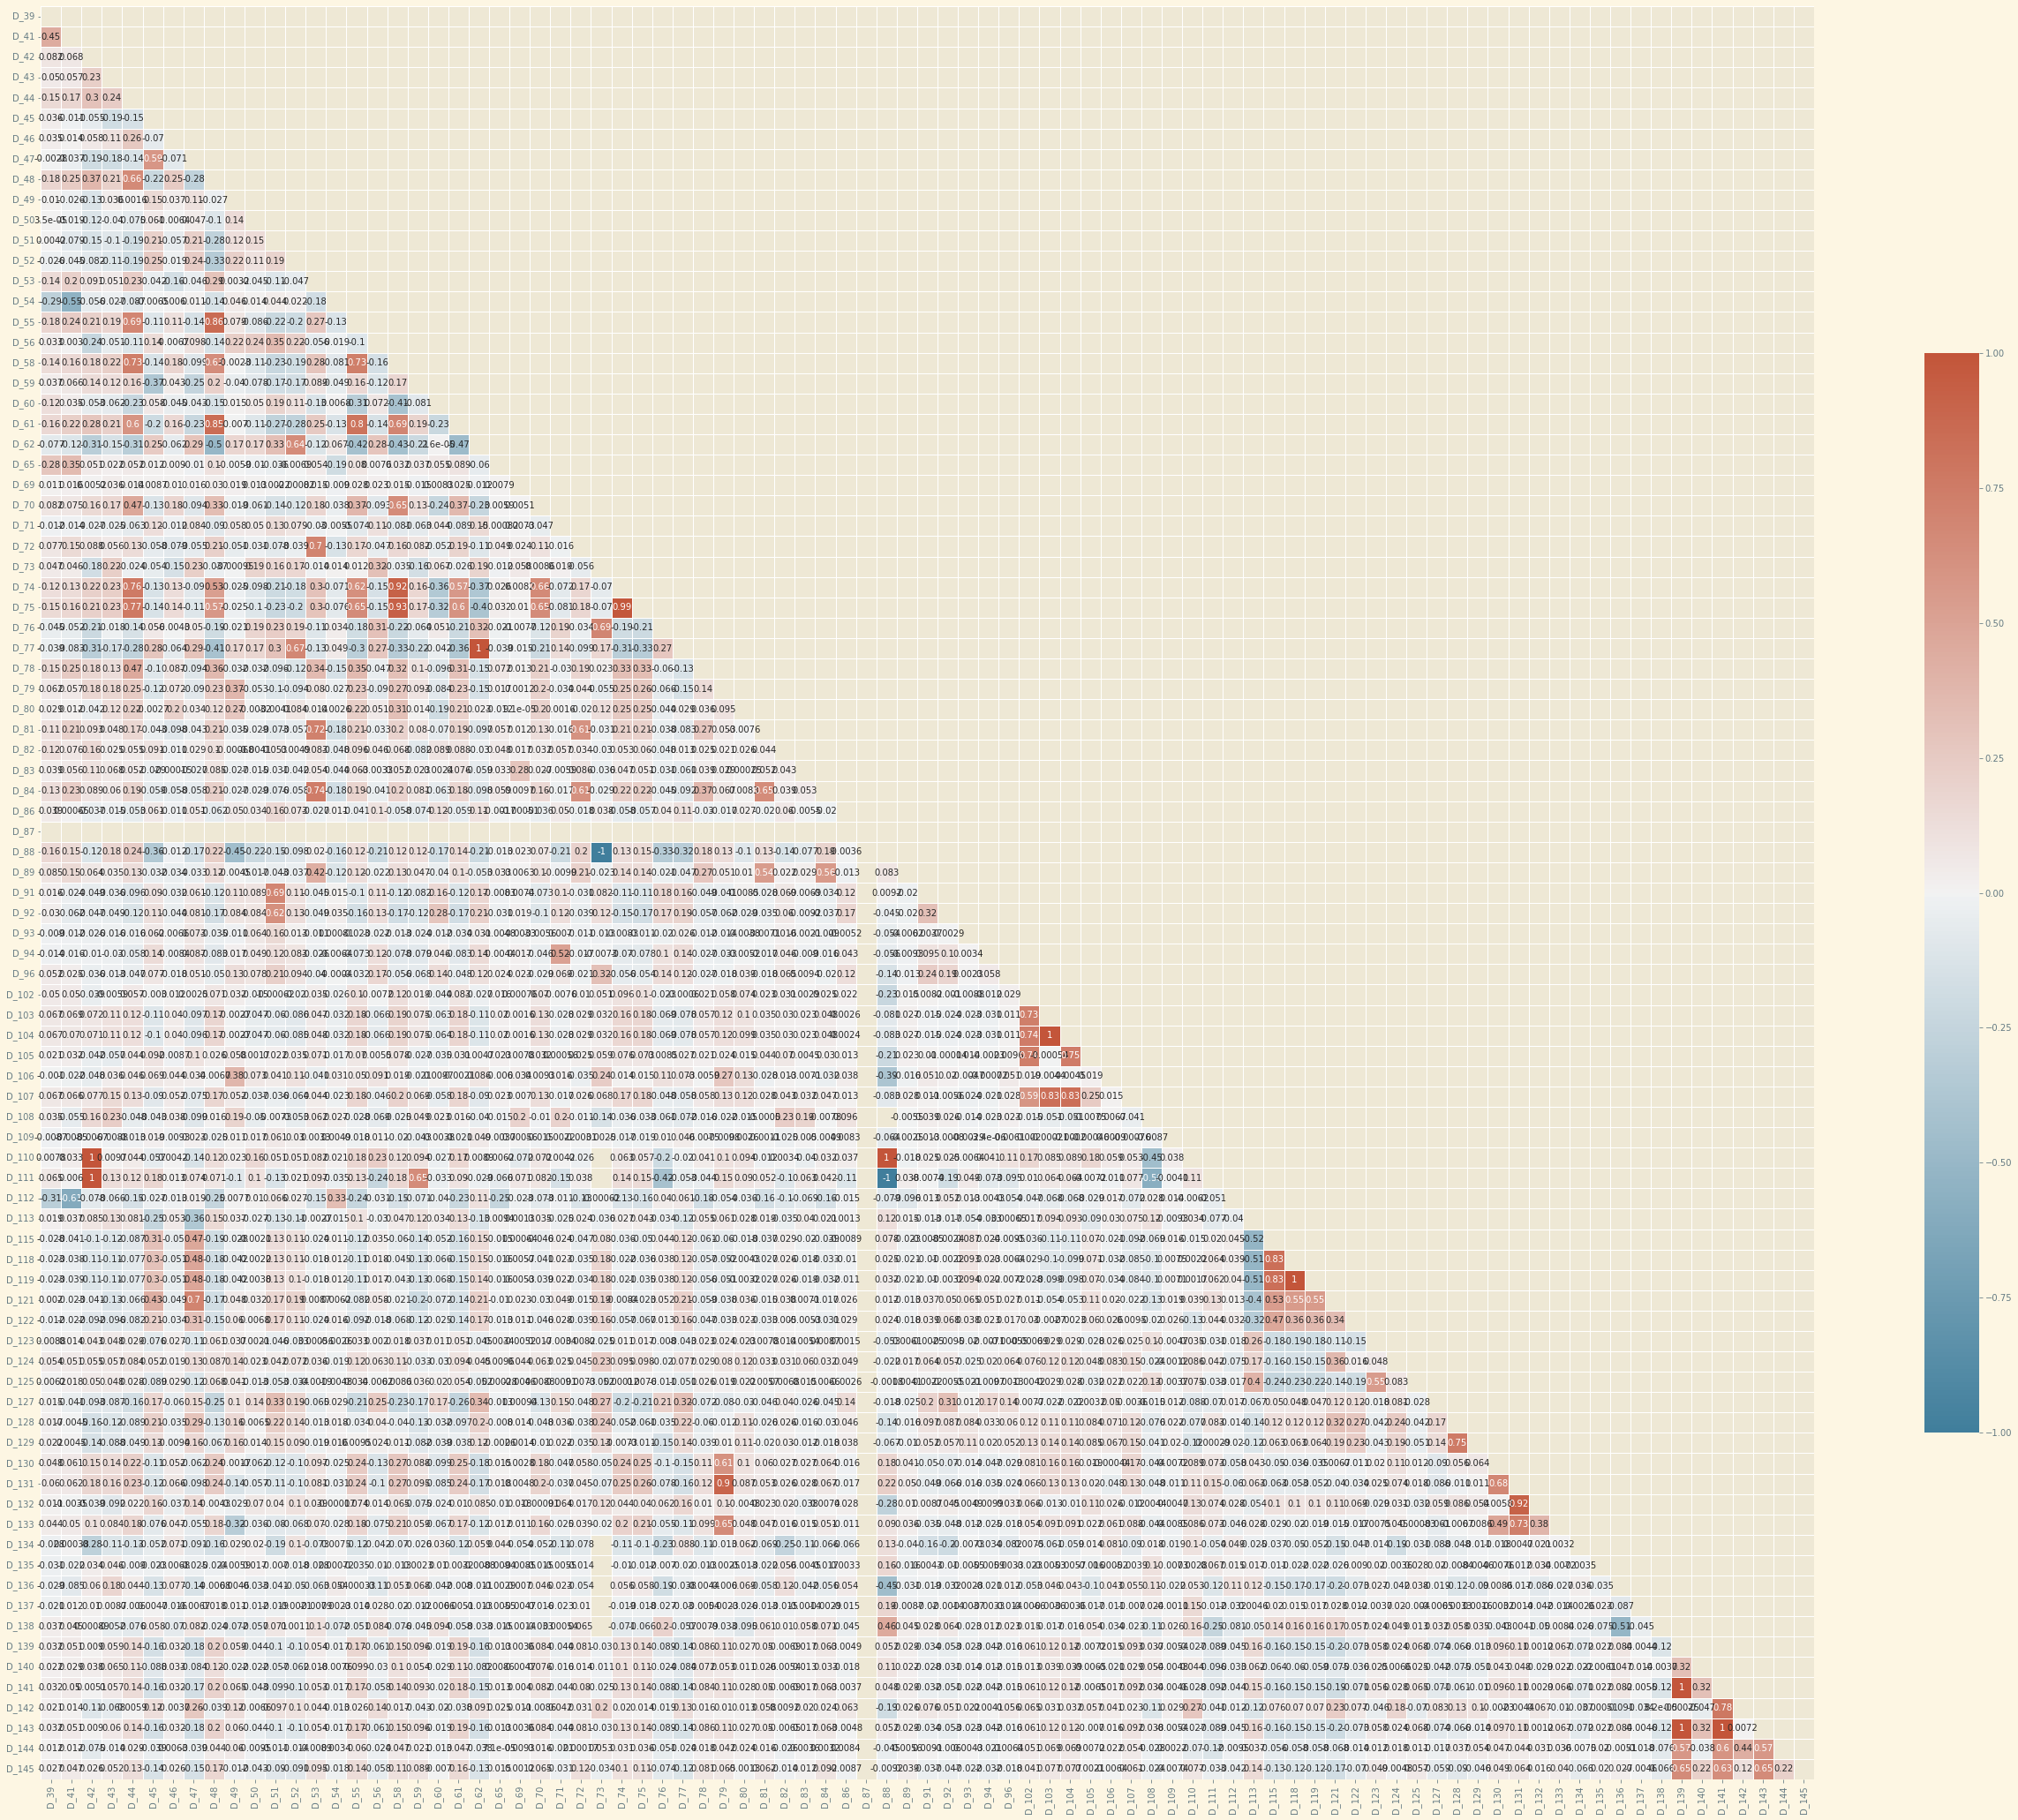

In [18]:
f, ax = plt.subplots(figsize=(45,45))
mat = train_df[deliq].corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

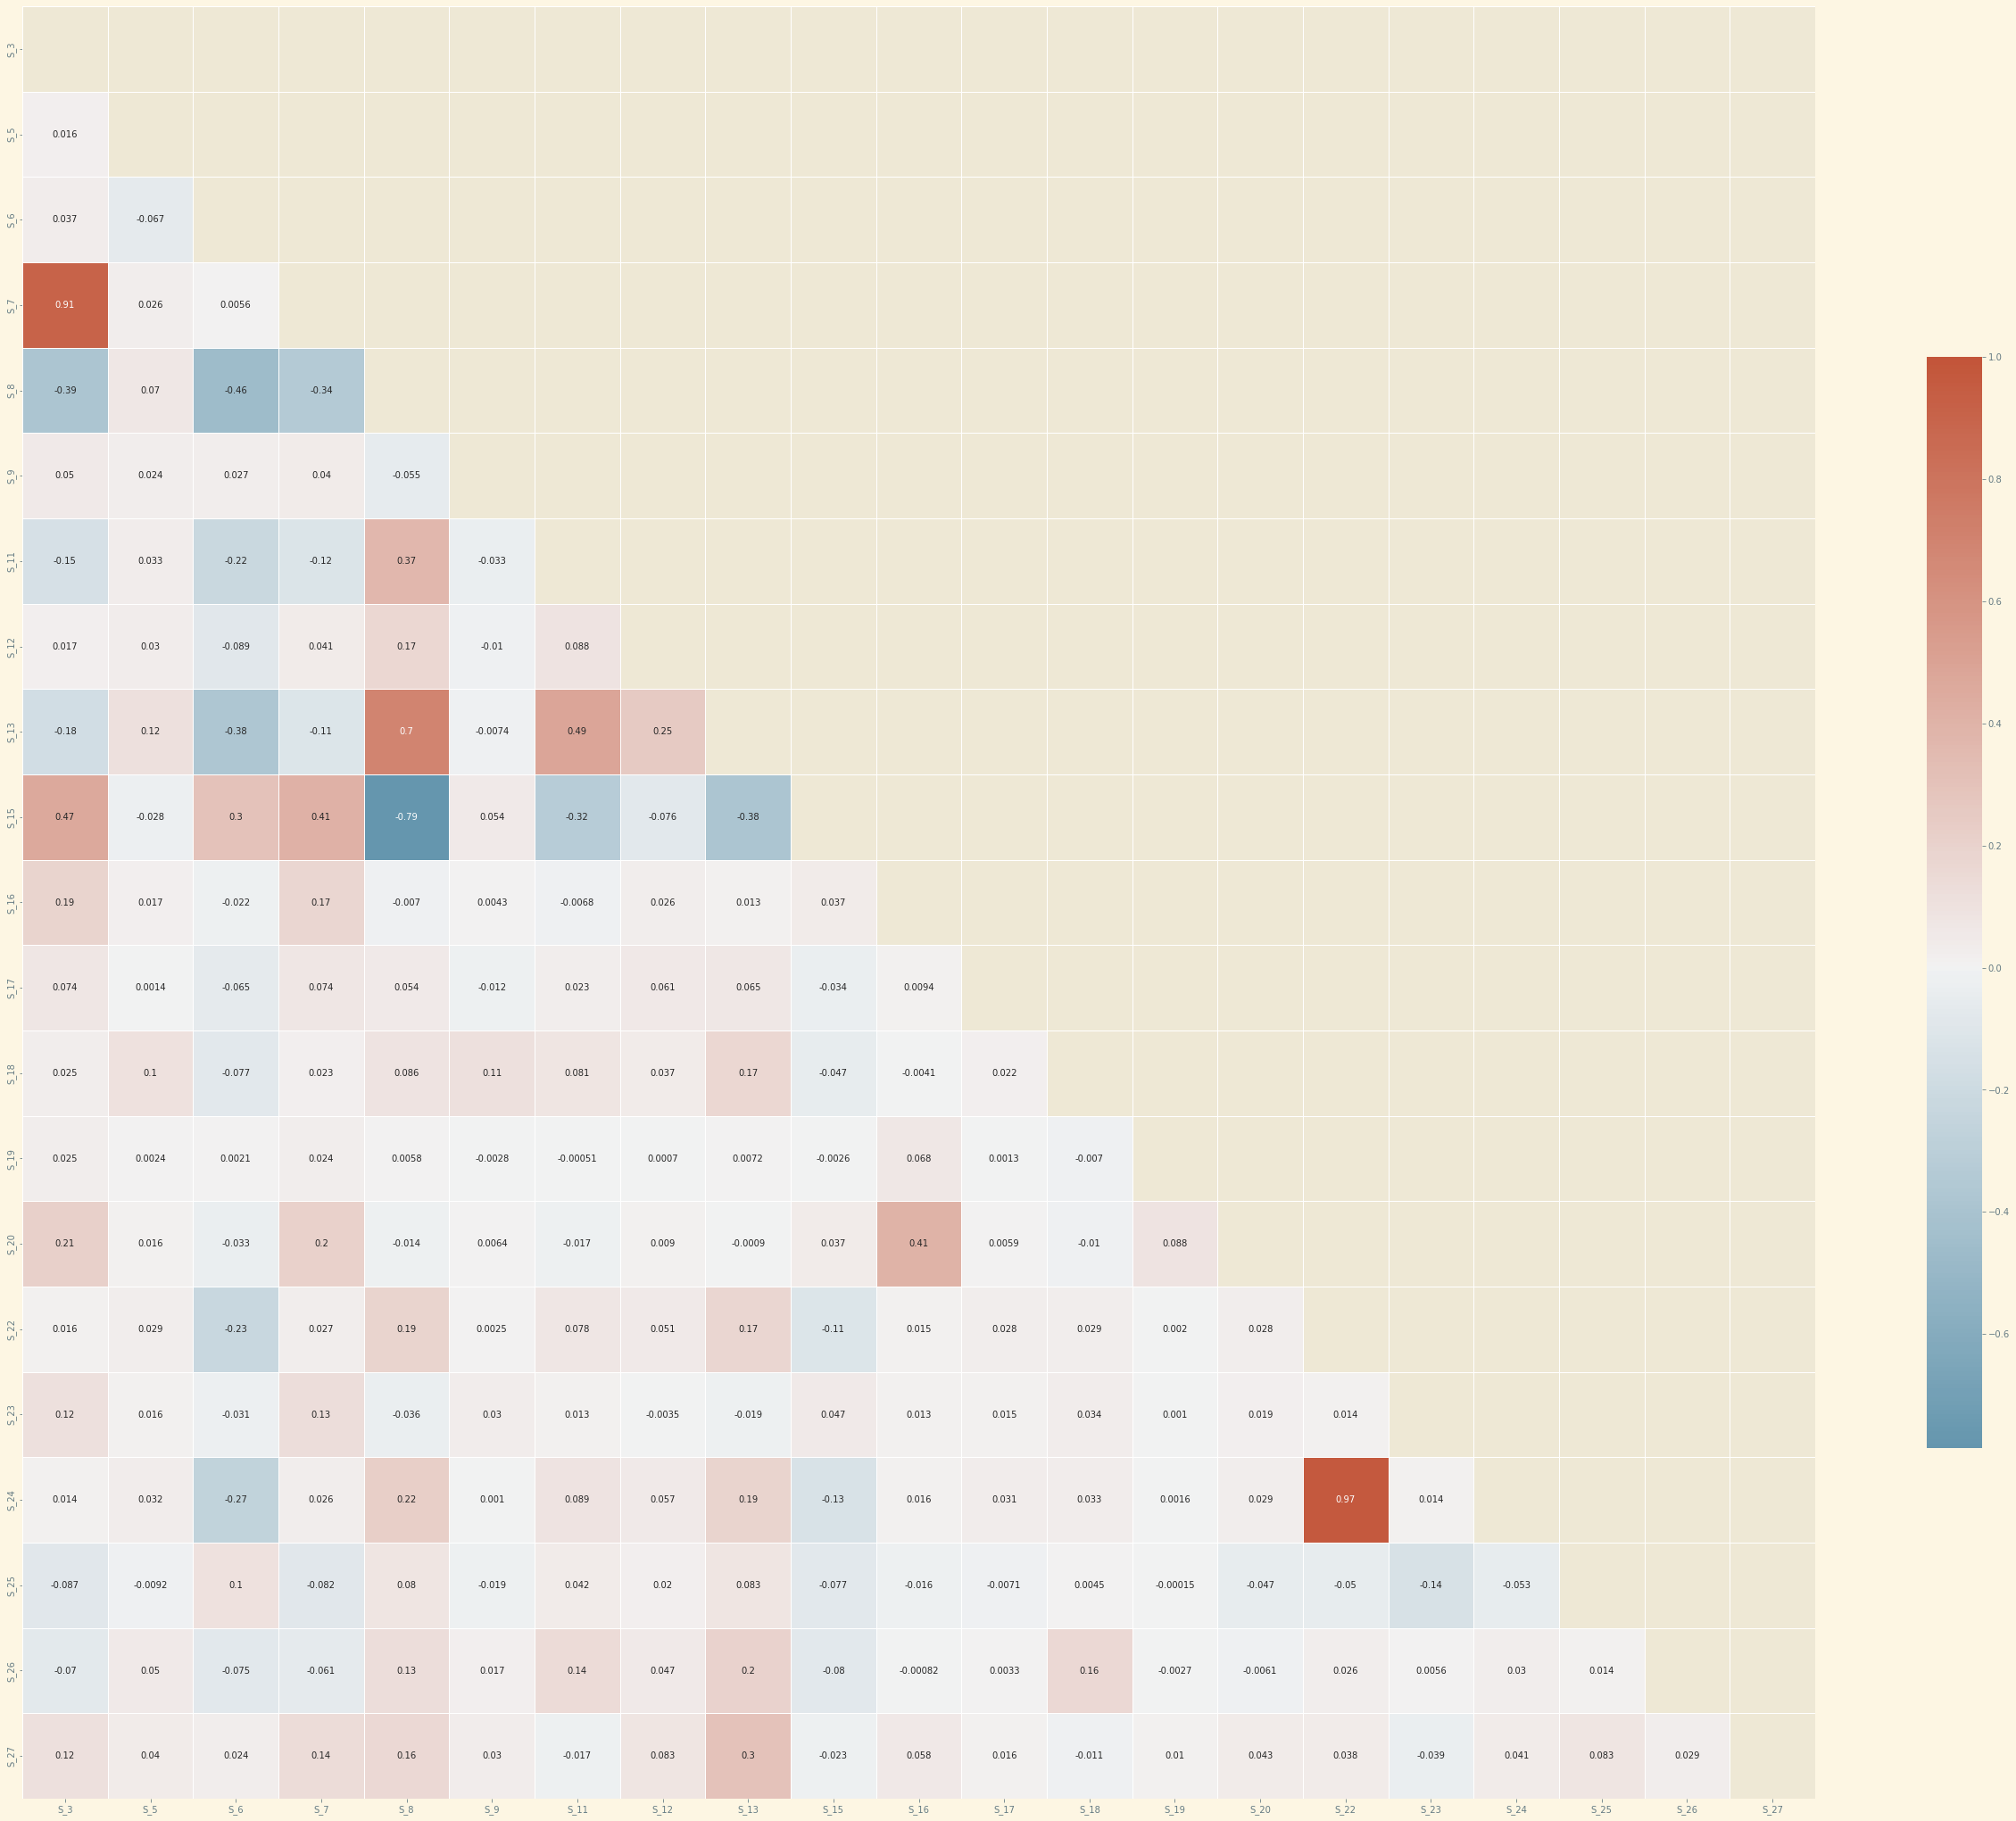

In [19]:
f, ax = plt.subplots(figsize=(45,45))
mat = train_df[spend].corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [21]:
f, ax = plt.subplots(figsize=(10,10))
mat = train_df[payment].corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [22]:
f, ax = plt.subplots(figsize=(45,45))
mat = train_df[risk].corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [23]:
f, ax = plt.subplots(figsize=(45,45))
mat = train_df[balance].corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# **<span style="color:#87CEEB;">Checking Missing values</span>**

In [16]:
for i in train_df.columns:
    print(f"{i}--->{((train_df[i].isnull().sum())/200000)*100}%")

customer_ID--->0.0%
P_2_mean--->0.044000000000000004%
P_2_std--->0.134%
P_2_min--->0.044000000000000004%
P_2_max--->0.044000000000000004%
P_2_last--->0.044000000000000004%
D_39_mean--->0.0%
D_39_std--->0.087%
D_39_min--->0.0%
D_39_max--->0.0%
D_39_last--->0.0%
B_1_mean--->0.0%
B_1_std--->0.087%
B_1_min--->0.0%
B_1_max--->0.0%
B_1_last--->0.0%
B_2_mean--->0.0005%
B_2_std--->0.08800000000000001%
B_2_min--->0.0005%
B_2_max--->0.0005%
B_2_last--->0.0005%
R_1_mean--->0.0%
R_1_std--->0.087%
R_1_min--->0.0%
R_1_max--->0.0%
R_1_last--->0.0%
S_3_mean--->1.0505%
S_3_std--->1.1735%
S_3_min--->1.0505%
S_3_max--->1.0505%
S_3_last--->1.0505%
D_41_mean--->0.0005%
D_41_std--->0.08800000000000001%
D_41_min--->0.0005%
D_41_max--->0.0005%
D_41_last--->0.0005%
B_3_mean--->0.0005%
B_3_std--->0.08800000000000001%
B_3_min--->0.0005%
B_3_max--->0.0005%
B_3_last--->0.0005%
D_42_mean--->6.2005%
D_42_std--->6.3385%
D_42_min--->6.2005%
D_42_max--->6.2005%
D_42_last--->6.2005%
D_43_mean--->1.8585%
D_43_std--->2.01

In [18]:
nan = pd.DataFrame(train_df.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/200000)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 70, 'Discard', 'Keep')

In [19]:
train_df

customer_ID  P_2_mean   P_2_std  \
0      0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.933594  0.024194   
1      00000fd6641609c6ece5454664794f0340ad84dddce9a2...  0.899902  0.022097   
2      00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  0.878418  0.028837   
3      000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  0.599121  0.020082   
4      00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...  0.891602  0.042316   
...                                                  ...       ...       ...   
16571  0956f2eafc5d8919835f76f6e40835b49900cf91c3de18...  0.678223  0.122665   
16572  0956f6dbb2671e10a40180b39ea793fb73633767ef70be...  0.878418  0.018330   
16573  095700a5c40952f9c134c6a71700bbd959098adfdcf2c7...  0.658203  0.036290   
16574  09572daa668d689b39d22d8a6a234d48141259b0675b0d...  0.855469  0.022351   
16575  09572fafe01b8bbb560809da84c7d1c8d9e79eb7287bc5...  0.590820  0.033357   

        P_2_min   P_2_max  P_2_last  D_39_mean  D_39_std  D_39_min  D_39_max  \
0      0.868652  0.960449  0.934570   0.010704  0.024440  0.001082  0.091492   
1      0.861328  0.929199  0.880371   0.215210  0.199123  0.002224  0.567383   
2      0.797852  0.904297  0.880859   0.004181  0.002759  0.000802  0.009705   
3      0.567383  0.623535  0.621582   0.048859  0.088490  0.000660  0.268555   
4      0.805176  0.940430  0.872070   0.004642  0.002883  0.000030  0.008682   
...         ...       ...       ...        ...       ...       ...       ...   
16571  0.375488  0.828125  0.375488   0.156372  0.277608  0.000146  0.711426   
16572  0.838379  0.921387  0.871094   0.004776  0.002874  0.000003  0.008621   
16573  0.578613  0.716309  0.687988   0.186768  0.191895  0.002926  0.530273   
16574  0.833008  0.880859  0.877930   0.066833  0.078206  0.004055  0.239990   
16575  0.539062  0.655273  0.655273   0.018723  0.031087  0.002060  0.090149   

       D_39_last  B_1_mean   B_1_std   B_1_min   B_1_max  B_1_last  B_2_mean  \
0       0.009117  0.012009  0.006546  0.001930  0.021652  0.009384  1.004883   
1       0.178101  0.025650  0.027750  0.006710  0.109619  0.034698  0.991211   
2       0.009705  0.004387  0.002786  0.001472  0.009995  0.004284  0.815430   
3       0.001082  0.059875  0.080538  0.005909  0.280029  0.012566  0.955078   
4       0.005573  0.005939  0.002475  0.000776  0.009804  0.007679  0.814453   
...          ...       ...       ...       ...       ...       ...       ...   
16571   0.004803  0.028473  0.027802  0.007858  0.104187  0.038727  0.862305   
16572   0.000003  0.024719  0.066053  0.000665  0.243530  0.243530  0.845703   
16573   0.006092  0.029587  0.018323  0.003620  0.065002  0.007820  1.003906   
16574   0.212280  0.024902  0.011150  0.010704  0.044403  0.030655  1.005859   
16575   0.002060  0.012466  0.004663  0.006172  0.022369  0.022369  0.929199   

        B_2_std   B_2_min   B_2_max  B_2_last  R_1_mean   R_1_std   R_1_min  \
0      0.003248  1.000000  1.009766  1.007812  0.004509  0.003081  0.000263   
1      0.051519  0.819824  1.008789  1.003906  0.006245  0.002128  0.001023   
2      0.003485  0.811035  0.819824  0.812500  0.006622  0.001920  0.003540   
3      0.080903  0.812012  1.009766  1.005859  0.005665  0.003473  0.000199   
4      0.003130  0.810547  0.819824  0.815918  0.004181  0.002581  0.000335   
...         ...       ...       ...       ...       ...       ...       ...   
16571  0.293151  0.007095  1.008789  0.007095  0.081787  0.189736  0.000885   
16572  0.071878  0.812012  1.007812  0.817871  0.023575  0.068744  0.000466   
16573  0.003291  1.000000  1.009766  1.002930  0.043610  0.137960  0.000755   
16574  0.003228  1.000977  1.009766  1.000977  0.005638  0.003126  0.000405   
16575  0.098644  0.812988  1.008789  1.007812  0.056152  0.156128  0.004398   

        R_1_max  R_1_last  S_3_mean   S_3_std   S_3_min   S_3_max  S_3_last  \
0      0.009224  0.006104  0.113220  0.011665  0.098877  0.135010  0.135010   
1      0.008995  0.006912  0.120605  0.023842  0.089783

# **<span style="color:#87CEEB;">Data to Plot</span>**

In [20]:
plt.figure(figsize = (45,20))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

In [21]:
discard=nan[nan["Usability"]!="Keep"]

In [22]:
delete_list=[]
for i in discard["feat"]:
    delete_list.append(i)

# **<span style="color:#87CEEB;">Feature Engineering</span>**

In [23]:
train=train_df.drop(delete_list,axis=1)

In [24]:
train_df.shape

(16576, 920)

In [25]:
train=train_df.drop(["customer_ID"],axis=1)

# **<span style="color:#87CEEB;">Splitting Train & Test</span>**

In [26]:
x=train.drop("target",axis=1)
y=train["target"]

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# **<span style="color:#87CEEB;">Null Value Imputation</span>**

In [28]:
si_num=SimpleImputer(strategy="median")
si_cat=SimpleImputer(strategy="most_frequent")

In [29]:
num_cols = [col for col in x if col not in cat_features]

In [30]:
x_tr=pd.DataFrame(si_num.fit_transform(x_train[num_df.columns]),columns=num_df.columns)
x_te=pd.DataFrame(si_num.transform(x_test[num_df.columns]),columns=num_df.columns)

In [31]:
x_train_cat=pd.DataFrame(si_cat.fit_transform(x_train[cat_df.columns]),columns=cat_df.columns)
x_test_cat=pd.DataFrame(si_cat.transform(x_test[cat_df.columns]),columns=cat_df.columns)

In [32]:
main_train=pd.concat([x_tr,x_train_cat],axis=1)
main_test=pd.concat([x_te,x_test_cat],axis=1)

In [33]:
main_train.isnull().sum()

P_2_mean        0
P_2_std         0
P_2_min         0
P_2_max         0
P_2_last        0
               ..
D_66_last       0
D_66_nunique    0
D_68_count      0
D_68_last       0
D_68_nunique    0
Length: 918, dtype: int64

# **<span style="color:#87CEEB;">Model Building</span>**

In [34]:
lr=DecisionTreeClassifier(max_depth=5)

In [35]:
lr.fit(main_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [36]:
pred=lr.predict(main_train)
pred1=lr.predict(main_test)

In [46]:
from sklearn. ensemble import RandomForestClassifier
# create the random forest with your hyperparameters.
model = RandomForestClassifier (n_estimators=100)
# fit the model to start training.

model. fit(main_train,y_train)
# get the importance of the resulting features.
importances = model.feature_importances_
# create a data frame for visualization.
final_df = pd. DataFrame({"Features": pd.DataFrame(main_train).columns, "Importances": importances})
final_df.set_index('Importances')

# sort in ascending order to better visualization.
final_df = final_df.sort_values("Importances")
# plot the feature importances in bars.
final_df.plot.bar(color = 'teal' )



<AxesSubplot:>

In [48]:
pred=model.predict(main_train)
pred1=model.predict(main_test)

In [54]:
from sklearn.model_selection import GridSearchCV

In [58]:
param_grid = {#"n_estimators" : [50,100,150],
              #"min_samples_split": [2, 5,7],
              "max_depth": [3,4,5, 7],
              #"min_samples_leaf": [1, 5],
              #"ccp_alpha":[0.0001,0.001,0.01,0.1]
             }

In [59]:
rc=RandomForestClassifier()
rfclf_grid = GridSearchCV(rc, param_grid, cv=3,verbose=1)
rfclf_grid.fit(main_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5, 7]}, verbose=1)

In [60]:
pred=rfclf_grid.predict(main_train)
pred1=rfclf_grid.predict(main_test)

# **<span style="color:#87CEEB;">Model Evaluation</span>**

In [39]:
def amex_metric(y_true, y_pred, return_components=False) -> float:
    """Amex metric for ndarrays"""
    def top_four_percent_captured(df) -> float:
        """Corresponds to the recall for a threshold of 4 %"""
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

In [61]:
amex_metric(y_train,pred)

0.6532494028191094

In [62]:
amex_metric(y_test,pred1)

0.5192823270305453